# Рекомендация тарифов

## Описание проекта

Оператор мобильной связи «Мегалайн» обнаружил, что многие из его клиентов продолжают пользоваться старыми архивными тарифами, в то время как новые более выгодные тарифы не получают должного внимания. Чтобы решить эту проблему и увеличить количество недовольных клиентов, «Мегалайн» решил создать систему, способную проанализировать поведение пользователей и предложить им наиболее подходящий тарифный план - «Смарт» или «Ультра». 

Для этого необходимо использовать данные о поведении уже перешедших на новые тарифы клиентов. Главной задачей проекта является построение модели, которая сможет провести классификацию и выбрать подходящий тариф для каждого клиента.

## Описание входных данных

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц

* `сalls` — количество звонков,
* `minutes` — суммарная длительность звонков в минутах,
* `messages` — количество sms-сообщений,
* `mb_used` — израсходованный интернет-трафик в Мб,
* `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

## Используемые библиотеки

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix

warnings.filterwarnings('ignore')
RANDOM_SEED = 240497

## Загрузка данных и анализ общей информации

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
except:
    data = pd.read_csv('users_behavior.csv')

In [3]:
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


 В датасете представлены данные по 3214 клиентам. В задаче к проекту сказано, что **предобработка данных не понадобится**, поэтому приступим к построению модели, но сначала оценим сбалансированность классов.

In [5]:
counts = data['is_ultra'].value_counts()
percent100 = data['is_ultra'].value_counts(normalize=True).mul(100).round(1).astype('str')+'%'
pd.DataFrame({'counts': counts, 'per100': percent100})

,counts,per100
0,2229,69.4%
1,985,30.6%


Клиентов, которые относятся к классу 0 почти в 2.3 раза больше, чем клиентов из класса 1. Посмотрим, как это влияет на обучение моделей.

## Формирование обучающей, валидационной и тестовой выборки

In [6]:
# сделаем разбивку данных в соотношении 70/15/15
train, test_val = train_test_split(data, test_size=0.3, random_state=RANDOM_SEED)
test, val = train_test_split(test_val, test_size=0.5, random_state=RANDOM_SEED)

print('Размер обучающей выборки:', train.shape)
print('Размер валидационной выборки:', val.shape)
print('Размер тестовой выборки:', test.shape)

Размер обучающей выборки: (2249, 5)
Размер валидационной выборки: (483, 5)
Размер тестовой выборки: (482, 5)


In [7]:
# выделим факторы и целевую переменную
X_train, y_train = train.drop(columns=['is_ultra']).values, train['is_ultra'].values
X_val, y_val = val.drop(columns=['is_ultra']).values, val['is_ultra'].values
X_test, y_test = test.drop(columns=['is_ultra']).values, test['is_ultra'].values

## Построение моделей

В данном разделе построим три различные модели: логистическую регрессию, дерево решений и модель случайного леса. Посмотрим как меняется качество, изменяя гиперпараметры моделей, построим графики.

### Логистическая регрессия

In [8]:
# построим модель логистичской регрессии без настроек гиперпараметров
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_val, y_val)

0.7784679089026915

Точность прогнозов на валидационной выборке составляет 77.8%. Посмотрим как будет меняться качество при изменении гиперпараметров.

In [9]:
params = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
          'penalty':['none', 'elasticnet', 'l1', 'l2'],
          'C':[0.001, 0.01, 0.1, 1, 10, 100]}


logreg = LogisticRegression()
grid_search_logreg = GridSearchCV(estimator = logreg,  
                                   param_grid = params,
                                   scoring = 'accuracy')


grid_search_logreg.fit(X_train, y_train)

print('Лучшая модель:', grid_search_logreg.best_estimator_)

Лучшая модель: LogisticRegression(C=10, penalty='l1', solver='liblinear')


In [10]:
logreg = grid_search_logreg.best_estimator_
logreg.fit(X_train, y_train)
logreg_res = round(logreg.score(X_val, y_val), 3)
print(logreg_res)

0.776


После перебора гиперпараметров лучшая модель логистической регрессии оказалась с параметрами `LogisticRegression(C=10, penalty='l1', solver='liblinear')`, однако точность модели даже немного ниже, чем в  варианте, где гиперпараметры заданы не были. 

### Дерево решений

In [11]:
tree_model = DecisionTreeClassifier(random_state=RANDOM_SEED)
tree_model.fit(X_train, y_train)
tree_model.score(X_val, y_val)

0.7370600414078675

Дерево решений без подбора гиперпараметров показывает точность меньше, чем логистическая регрессия. Переберем максимальную глубину дерева.

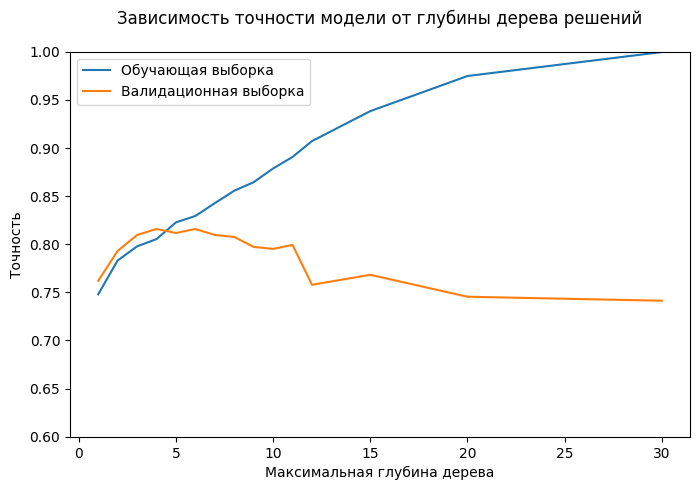

,1,2,3,4,5,6
train,0.747888,0.783015,0.797688,0.805247,0.822588,0.829257
validation,0.761905,0.792961,0.809524,0.815735,0.811594,0.815735


In [12]:
max_depth = [1,2,3,4,5,6,7,8,9,10,11,12,15,20,30]

train_acc = []
val_acc = []

for depth in max_depth:
    tree_model = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=depth)
    tree_model.fit(X_train, y_train)
    
    val_acc.append(tree_model.score(X_val, y_val))
    train_acc.append(tree_model.score(X_train, y_train))
    
# построим график результатов обучения
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(max_depth, train_acc)
ax.plot(max_depth, val_acc)

ax.set_ylim(0.6,1)
ax.set_ylabel('Точность')
ax.set_xlabel('Максимальная глубина дерева')
ax.legend(['Обучающая выборка', 'Валидационная выборка'])
ax.set_title('Зависимость точности модели от глубины дерева решений', y=1.05)

plt.show()

# выведем в виде таблицы результаты
d = {'train': train_acc,
     'validation': val_acc}
results = pd.DataFrame(data=d, index=max_depth)
display(results.loc[:6].T)

В данном случае подбор такого гиперпараметра, как максимальна глубина дерева решений сыграл свою роль. Точность прогнозов выросла до 81.5% на валидационной выборке. Также на графике наглядно представлено, что начиная с глубины дереве равной 7 начинается переобучение модели, поэтому определим лучшую модель так:

In [21]:
tree_model = DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=6)
tree_model.fit(X_train, y_train)
tree_res = round(tree_model.score(X_val, y_val), 3)
print(tree_res)

0.816


### Случайный лес

In [14]:
params = { 
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' : ['gini', 'entropy']
}

# rfc_model = RandomForestClassifier(random_state=RANDOM_SEED)
# grid_search_rfc = GridSearchCV(estimator=rfc_model,
#                                param_grid=params,
#                                cv=5,
#                                scoring = 'accuracy')
# grid_search_rfc.fit(X_train, y_train)
# grid_search_rfc.best_params_

# OUTPUT:
# {'criterion': 'gini',
#  'max_features': 'auto',
#  'n_estimators': 200}

В результате перебора гиперпараметров получили "лучшую" модель. Для наглядности вручную подберем оптимальную глубину деревьев, чтобы посмотреть, когда модель начнет переобучаться.

In [15]:
train_acc = []
val_acc = []

for depth in max_depth:
    rfc_model = RandomForestClassifier(random_state=RANDOM_SEED,
                                       criterion='gini',
                                       max_depth=depth,
                                       max_features='auto',
                                       n_estimators=200)
    rfc_model.fit(X_train, y_train)
    
    val_acc.append(rfc_model.score(X_val, y_val))
    train_acc.append(rfc_model.score(X_train, y_train))

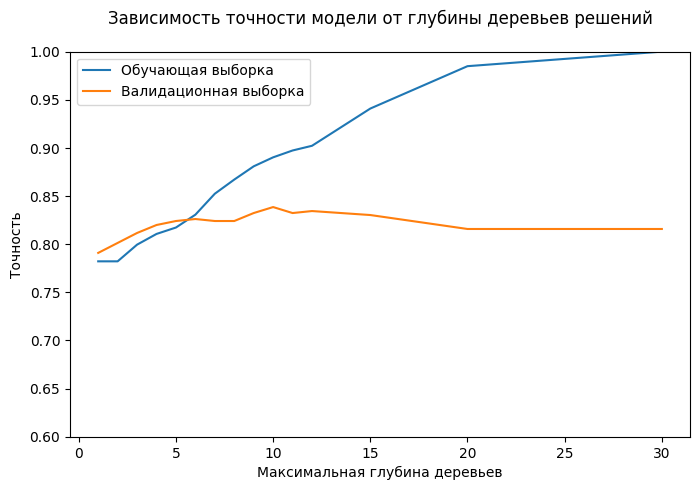

,1,2,3,4,5,6,7,8,9,10,11,12,15,20
train,0.782125,0.782125,0.799466,0.810582,0.817252,0.830591,0.852379,0.867052,0.880836,0.890173,0.897288,0.902179,0.940863,0.984882
validation,0.790890,0.801242,0.811594,0.819876,0.824017,0.826087,0.824017,0.824017,0.832298,0.838509,0.832298,0.834369,0.830228,0.815735


In [16]:
# построим график результатов обучения
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(max_depth, train_acc)
ax.plot(max_depth, val_acc)

ax.set_ylim(0.6,1)
ax.set_ylabel('Точность')
ax.set_xlabel('Максимальная глубина деревьев')
ax.legend(['Обучающая выборка', 'Валидационная выборка'])
ax.set_title('Зависимость точности модели от глубины деревьев решений', y=1.05)

plt.show()

# выведем в виде таблицы результаты
d = {'train': train_acc,
     'validation': val_acc}
results = pd.DataFrame(data=d, index=max_depth)
display(results.iloc[:-1].T)

После глубины деревьев равной 10 точность на валидационной выборке начинает снижаться. Предположим, что это оптимальная глубина деревьев.

In [17]:
rfc_model = RandomForestClassifier(random_state=RANDOM_SEED,
                                       criterion='gini',
                                       max_depth=10,
                                       max_features='auto',
                                       n_estimators=200)
rfc_model.fit(X_train, y_train)
rfc_res = round(rfc_model.score(X_val, y_val), 3)
print(rfc_res)

0.839


In [18]:
svod_d = {'LogReg': [logreg_res],
        'TreeDecision': [tree_res],
        'RandomForest': [rfc_res]}

svod = pd.DataFrame(data=svod_d, index=['accuracy'])
display(svod)

,LogReg,TreeDecision,RandomForest
accuracy,0.776,0.812,0.839


В данном разделе были построены три модели: логистичсекая регрессия, дерево решений и модель случайного леса. В результате чего были получены следующие результаты точности на валидационной выборке: 
1. Логистическая регрессия — 77.6% 
2. Дерево решений — 81.6%
3. Случайный лес — 83.9%

Таким образом, наибольшую точность показала модель случайного леса. Посмотрим на результаты на тестовой выборке в следующем разделе.

## Проверка моделей на тестовой выборке

In [19]:
print('Точность модели логистической регрессии на тестовой выборке:',
      round(logreg.score(X_test, y_test), 3))
print('Точность модели дерева решений на тестовой выборке:',
      round(tree_model.score(X_test, y_test), 3))
print('Точность модели случайного леса на тестовой выборке:',
      round(rfc_model.score(X_test, y_test), 3))

Точность модели логистической регрессии на тестовой выборке: 0.761
Точность модели дерева решений на тестовой выборке: 0.782
Точность модели случайного леса на тестовой выборке: 0.79


Модель случайного леса показала наиболее высокий процент точности. Построим матрицу ошибок и посмотрим какие классы модель предсказывает лучше или хуже.

### Проверка модели на адекватность

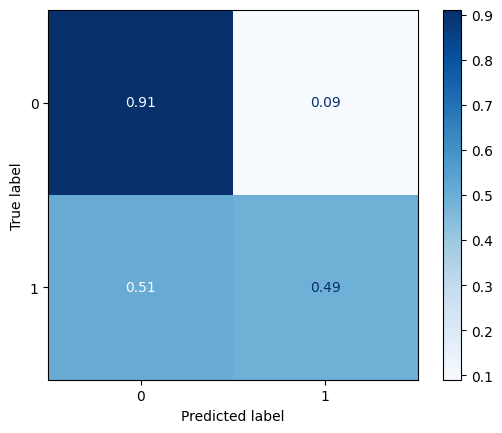

In [20]:
plot_confusion_matrix(estimator=rfc_model, X=X_test, y_true=y_test,
                      normalize='true', cmap='Blues')
plt.show()

Модель достаточно хорошо предсказывает клиентов с тарифом "Смарт", однако клиентов с тарифом "Ультра" модель предсказывает почти что случайным образом, вероятно это связано с тем, что соотношение классов в обучающей выборке 70/30.

## Общий вывод

В ходе выполнения данной работы были построены три различные модели: логистическая регрессия, дерево решений и модель случайного леса. Основной метрикой являлась точность и модель случайного леса показала наибольшую точность на тестовой выборке - 79%, однако на матрице ошибок выяснилось, что клиентов, которые используют тариф "Ультра" модель предсказывает с вероятностью 49%, что является плохим результатом. Клиентов же с тарифом "Смарт" модель определяет с достаточно высоким процентом правильно - 91%.